<a href="https://colab.research.google.com/github/MattiaVerticchio/PersonalProjects/blob/master/ProductClassification/ComputerVisionImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Product Images via Deep Learning

> **Abstract**
>
> The objective of this notebook is to classify images of the products contained in the Zalando Research Dataset. The dataset contains grayscale images and ten different categories of products. The framework chosen for the task is Auto-Keras, using Keras and TensorFlow as backend. We’ll search for a neural architecture that fits our project and compare it to the official [Zalando Research benchmark](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com). The results are in line with the benchmark, and the accuracy metric is 3% higher.

## Framework setup
As the central framework for this task, we’ll use [Auto-Keras](https://arxiv.org/abs/1806.10282). It’s an efficient neural architecture search system developed by DATA Lab at Texas A&M University. It leverages a variant of Bayesian Optimization to guide deep neural network morphism and find the optimal architecture for our task and dataset, using Keras and TensorFlow as backend.
First, we have to install it with its dependency, [Keras-Tuner](https://keras-team.github.io/keras-tuner/), which is the hyperparameter optimization library used by Auto-Keras.

In [ ]:
%%bash
pip install -q git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1 autokeras

## Imports
Now we can import the TensorFlow dataset loading tool and Auto-Keras, as well as plotting tools to examine the dataset. 

In [ ]:
from tensorflow.keras.datasets import fashion_mnist  # Dataset loading tool
import autokeras as ak                               # Learning library
import matplotlib.pyplot as plt                      # Visualization tools
%matplotlib inline                                   # Notebook settings
%config InlineBackend.figure_format = 'retina'       # High resolution plots

## Loading the data
We can now load the dataset into four NumPy arrays.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


The arrays `x_train` and `x_test` contain the images as matrixes of grey pixels (in the range 0–255). `y_train` and `y_test` store the class of each image according to the following map.

In [ ]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

Let’s plot a couple of examples.

In [ ]:
def plot(n):                              # Function to plot
    plt.imshow(x_train[n]);               # N-th image
    plt.title(label_map.get(y_train[n]))  # Adding the title from dictionary map
    plt.colorbar();                       # Adding legend bar

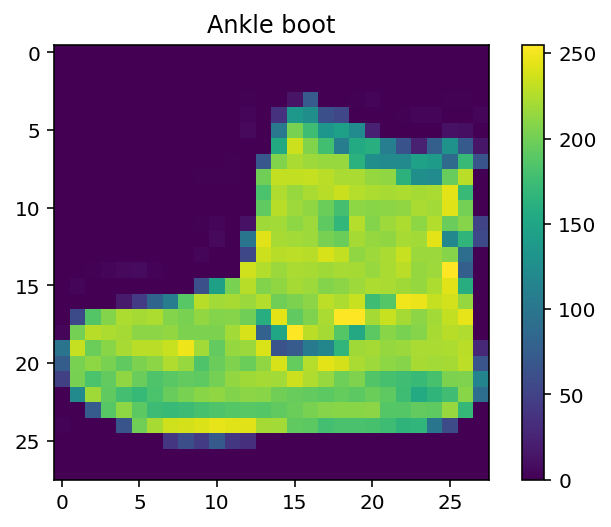

In [ ]:
plot(0)

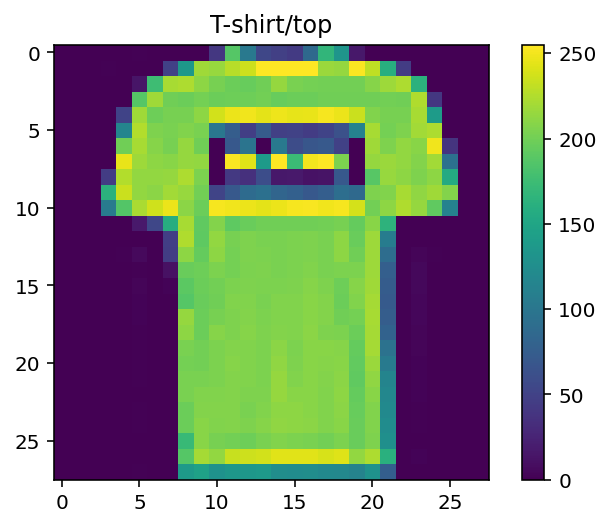

In [ ]:
plot(1)

## Building the model
`ImageClassifier` is the class that initializes the model search. Here I set the number of `trials` to avoid taking too much time for model exploration, but it can be any positive integer. It explores different model architectures by tree-based Bayesian Optimization search. We’ll try only the first one as it’s time-consuming on Google Colab’s GPU, where I’m running this notebook.

In [ ]:
trials = 1

clf = ak.ImageClassifier(             # Initialize the ImageClassifier
    num_classes=None,                 # Infer the number of classes
    multi_label=False,                # Only one output
    loss='categorical_crossentropy',  # Select the loss metric
    metrics='accuracy',               # Metric to watch
    project_name='image_classifier',  # Name of the folder
    max_trials=trials,                # Just try one model
    directory=None,                   # Automatic folder creation
    objective='val_loss',             # Validation set crossentropy
    tuner=None,                       # Automatic hyperparameter tuner selection
    overwrite=True,                   # Don't load previous experiments
    seed=42                           # Set a seed to replicate the experiment
)

### Neural Architecture Search
It’s all ready to start exploring the models.

In [ ]:
clf.fit(                   # Fit the model
    x=x_train,             # Training features
    y=y_train,             # Training labels
    epochs=None,           # Automatic number of epochs
    callbacks=None,        # No callbacks
    validation_split=0.2,  # Validation data split
    validation_data=None   # Use a portion of training data
)

Trial 1 Complete [00h 02m 33s]
val_loss: 0.2193739414215088

Best val_loss So Far: 0.2193739414215088
Total elapsed time: 00h 02m 33s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4301 - accuracy: 0.8457
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3134 - accuracy: 0.8887
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2775 - accuracy: 0.9012
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2567 - accuracy: 0.9069
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2413 - accuracy: 0.9120
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2318 - accuracy: 0.9145
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2208 - accuracy: 0.9195
Epoch 8/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2120 - accuracy: 0.9214
Epoch 9/15
1

We can now export the model. It’s a convolutional multi-layer neural network with the following architecture.

In [ ]:
model = clf.export_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
normalization (Normalization (None, 28, 28, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)             

## Testing the model
The benchmark chosen for this dataset is the accuracy reported on [the official Zalando Research website](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com). The best accuracy is 0.897, scored by a C-Support Vector Classification model.

Let’s now test the model on the holdout test set.

In [ ]:
current = clf.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2249 - accuracy: 0.9239


In [ ]:
previous = 0.897
improvement = (current[1] - previous) * 100

print(f'The accuracy improved by {round(improvement, 1)}%.')

The accuracy improved by 2.7%.


We scored an accuracy of ~92% with only one model explored, outperforming the benchmark by almost 3%. 